Import necessary libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

Import Phoenix Subdivision Shapefile from the Census County Subdivision shapefiles for Arizona.

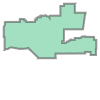

In [ ]:
p = os.path.join('data', 'tl_2025_04_cousub', 'tl_2025_04_cousub.shp')
counties = gpd.read_file(fp)

counties.columns = (counties.columns                # Clean to lower snake case 
                    .str.lower()             
                    .str.replace(' ' , '_'))

pheonix = counties[counties['name'] == 'Phoenix']   # Subset to Pheonix subdivison
pheonix_polygon = pheonix.geometry.iloc[0]
pheonix_polygon                                     # Verify shape is correct 

In [66]:
# Bounding‑box coordinates for catalog search (minx, miny, maxx, maxy)

bbox_coords = [-112.826843, 32.974108, -111.184387, 33.863574]
bbox_coords

[-112.826843, 32.974108, -111.184387, 33.863574]

In [67]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:

io_collection = catalog.get_child('io-biodiversity')
io_collection

<CollectionClient id=io-biodiversity>

In [6]:
# Search MPC catalog 
search = catalog.search(collections= ['io-biodiversity'], 
                        bbox = bbox_coords)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


In [17]:
# Select unique search item 
io_2017 = items[0]
io_2017 = rioxr.open_rasterio(io_2017.assets['data'].href)
io_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [16]:
io_2020 = items[3]
io_2020 = rioxr.open_rasterio(io_2020.assets['data'].href)
io_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
 #Match the CRS and verify update 

pheonix_match = pheonix.to_crs(io_2017.rio.crs)
assert pheonix_match.crs == io_2017.rio.crs 

In [69]:
# Clip large raster to detailed geometry in two steps 

pheonix_step1 = io_2017.rio.clip_box(*pheonix_match.total_bounds)

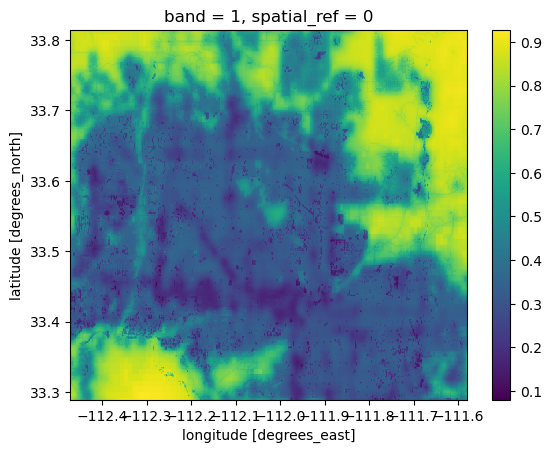

In [27]:
pheonix_step1.plot()

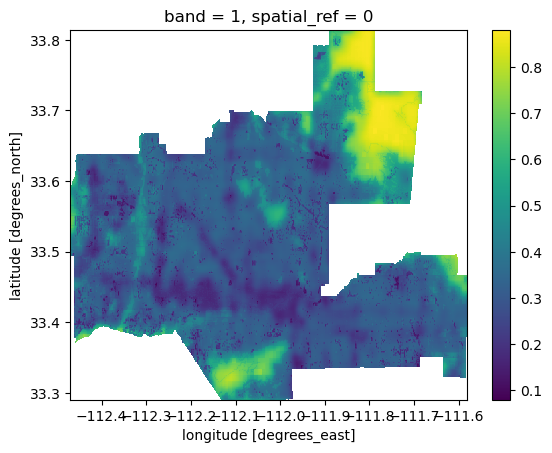

In [ ]:
pheonix_step2 = pheonix_step1.rio.clip(pheonix_match.geometry)
pheonix_step2.plot()

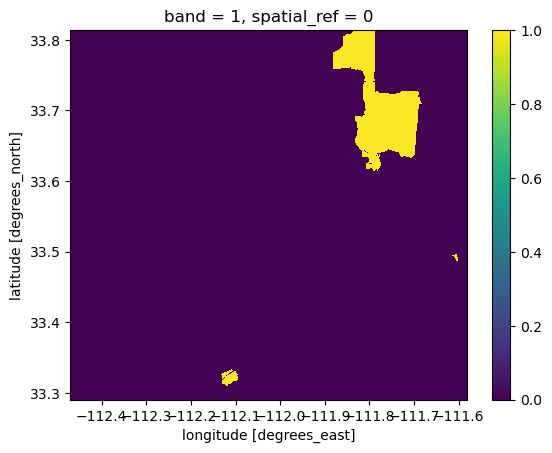

In [24]:
bii_2017 = pheonix_step2 > 0.75

bii_2017.plot()

In [28]:
# Clip large raster to detailed geometry in two steps 

io_2020_step1 = io_2020.rio.clip_box(*pheonix_match.total_bounds)

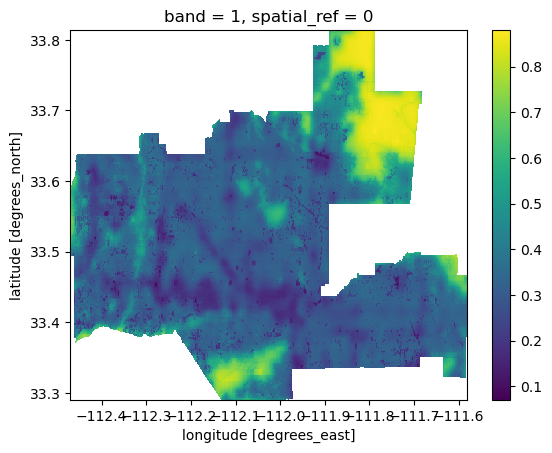

In [29]:
io_2020_step2 = io_2020_step1.rio.clip(pheonix_match.geometry)
io_2020_step2.plot()

xarray.core.dataarray.DataArray

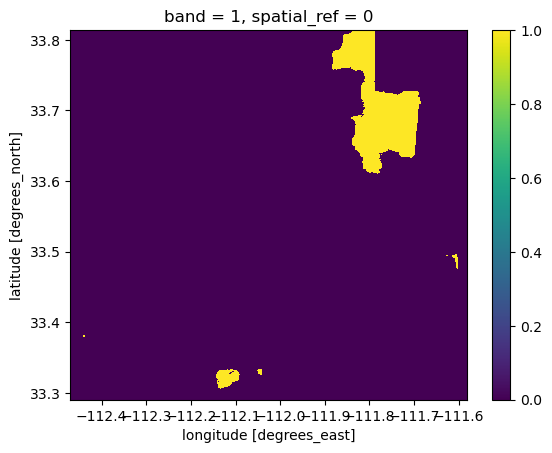

In [ ]:
bii_2020 = io_2020_step2 > 0.75
bii_2020.plot()

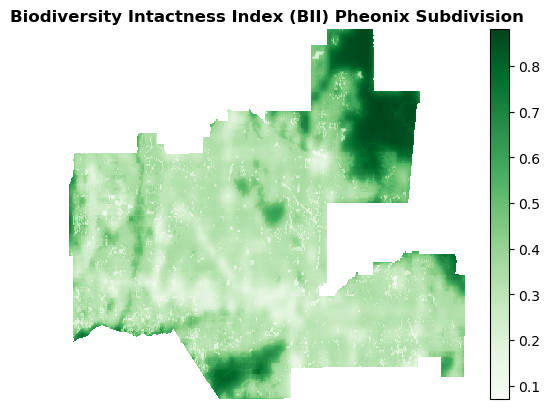

In [63]:
# Plot
fig, ax = plt.subplots()  # Adjust figure size

io_2020_step2.plot(
    ax=ax, 
    cmap = 'Greens')

ax.set_title("Biodiversity Intactness Index (BII) Pheonix Subdivision", 
             fontweight = "bold")  

# Remove axes labels
ax.axis("off")
plt.show()